# EDA Notebook

## Data Understanding

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats

plt.style.use('bmh')
%matplotlib inline

In [199]:
# Load Kings county database and preview first few entries
kc_df = pd.read_csv('data/kc_house_data.csv')
kc_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [200]:
# Taking a look at all the columns, data types, and missing entries
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The data contains 21 total columns, 12 of type int or float, and 6 of type object. It contains:

- `id` column which have a unique id value for each house
- `date` column with the sale date (Years 2014 - 2015)
- `price` column with the price of sale and our target variable
    - <p>mean: \$540296</p>
    - <p>std: \$367368</p>
- `bedrooms`, `bathrooms` and `floors` columns with counts of each in their respective house
- four area variables defining the square footage of living space, lot space, area of house apart from the basement, and area of the basement.
- two area variables describing the living and lot area of the 15 nearest neighbors
- `waterfront` variable of whether the house is on a waterfront (Yes/No)
- `view` describing quality of view from house
    - (None, Fair, Average, Good, Excellent)
- `condition` for the overall maintanence condtion of the house
    - (Poor, Fair, Average, Good, Very Good)
- `grade` describing overall construction and design grade of the house 
    - (Poor, Low, Fair, Low Average, Average, Good, Better, Very Good, Excellent, Luxury, Mansion)
- `yr_built` for when the house was built
- `yr_renovated` for when house was renovated last (if applicable)
- three location columns detailing `zipcode`, latitude (`lat`) and longitude (`long`) of the house.
    - Our data consists of an area covering 70 zipcodes


In [201]:
# Checking the years spanned by the data set
sales_year = kc_df.date.map(lambda x: int(x[-4:]))

print('The data spans the years {} to {}'.format(min(sales_year), max(sales_year)))

# finds mean and standard deviation of price
print('Sales price mean: ${}, stdev: ${}'.format(int(kc_df.price.mean()),int(kc_df.price.std())))

The data spans the years 2014 to 2015
Sales price mean: $540296, stdev: $367368


In [202]:
# Checking view values
kc_df.view.value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [203]:
# Checking condition values
kc_df.condition.value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [204]:
# Checking grade values
kc_df.grade.value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [205]:
# Checking how many unique zipcodes are included in the dataset
num_of_zip = len(kc_df.zipcode.unique())
print('There are {} unique zipcodes in this data set'.format(num_of_zip))

There are 70 unique zipcodes in this data set


## Data Preparation


At first glance, the columns for `id`, latitude (`lat`), and longitude (`long`) can be removed. The `id` column is good for reference, but not good for a linear regression model. The latitude and longitude appear to be difficult variables to deal with since they describe an exact location. In a linear regression model their seperate coefficients would only be good for how far in a cordinal direction they are. Having zones like a zipcode would be preferable as that defines a region, though having a 70 unique zipcodes in our data set would create a lot of columns if they were treated categorically and one hot encoded. Therefore the `zipcode` column will also be ommitted from our calculations. Another column that can be removed is the `date`. If our data set spanned a longer time this column may be used to adjust for inflation, or observe outside conditions that caused housing prices to drastically change like the 2006 housing bubble. Since our data only spans the years of 2014 and 2015 this isn't necessary.

We also have to consider which columns can actually pertain to our problem. We are looking for the best variables to improve to increase the sales price. Variables like `waterfront`, `sqft_lot`, `view`, `yr_built`, `yr_renovated`, `sqft_basement`, `sqft_living15` and `sqft_lot15` are variables that depend on location or are hard to change. Considering that these variables are most likely impossible to change, they will also be ommitted from our calculations.

In [206]:
# Dropping unnecessary columns from original dataset
unn_columns = ['id', 'date', 'lat', 'long', 'zipcode', 'waterfront',
               'view', 'yr_built', 'yr_renovated', 'sqft_living15',
              'sqft_lot15', 'sqft_lot', 'sqft_basement']

kc_df_iprep = kc_df.drop(columns=unn_columns, axis=1).copy()
kc_df_iprep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   floors       21597 non-null  float64
 5   condition    21597 non-null  object 
 6   grade        21597 non-null  object 
 7   sqft_above   21597 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 1.3+ MB


We now need to handle the object columns. 

The `grade` columns values already have a numerical ranking assigned to them followed by the description. Therefore we will just remove the description for each.

The `condition` column only contains the description, so they will be replaced using the map below.

- Poor: 1
- Fair: 2
- Average: 3
- Good: 4
- Very Good: 5

The mapping data will be saved for later reference.

In [207]:
def initial_prep(df):
#     Maps new values for condition column
    condition_map = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
    df.condition = df.condition.map(condition_map)
    
    unique_values = df.grade.unique()
    grade_map = {}
    
#     Creates grade map for later reference
    for unique_value in unique_values:
        grade_map[int(unique_value[:2])] = unique_value[2:].strip()

#    Function to take only numeric value of grade rating
    def grade_change(ds):
        return int(ds[:2])

#     Takes only numerical value of grade rating    
    df.grade = df.grade.map(grade_change)
    
    return (df, condition_map, grade_map)

In [208]:
kc_df_iprep, condition_map, grade_map = initial_prep(kc_df_iprep)
kc_df_iprep

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above
0,221900.0,3,1.00,1180,1.0,3,7,1180
1,538000.0,3,2.25,2570,2.0,3,7,2170
2,180000.0,2,1.00,770,1.0,3,6,770
3,604000.0,4,3.00,1960,1.0,5,7,1050
4,510000.0,3,2.00,1680,1.0,3,8,1680
...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,3.0,3,8,1530
21593,400000.0,4,2.50,2310,2.0,3,8,2310
21594,402101.0,2,0.75,1020,2.0,3,7,1020
21595,400000.0,3,2.50,1600,2.0,3,8,1600


With the initial prep done, let's split the dataset into a training and test set to later see if our models properly represent the data. Then we will standardize the data using StandardScaler.

In [209]:
from sklearn.model_selection import train_test_split

In [210]:
# Target Variable
y = kc_df_iprep.price.copy()

# independent variables
X = kc_df_iprep.drop(columns='price', axis=1).copy()

# Splits the data into two sets at a 4:1 ratio of variables for train:test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

## Modeling

The initial data preparation is completed, it's time to start our first model which will be a simple linear regression of the variable with the highest correlation to price.

### Base Model


In [211]:
# Checks correlation of all variables to price
pd.concat([X_train, y_train], axis=1).corr().price.sort_values(ascending=False)

price          1.000000
sqft_living    0.700510
grade          0.664836
sqft_above     0.605636
bathrooms      0.521242
bedrooms       0.304175
floors         0.260027
condition      0.032537
Name: price, dtype: float64

The variable with the highest correlation to `price` is `sqft_living`. Let's take a look at the scatter plot and histograms for the variables.

In [212]:
def base_plots(x, y):
    '''
    Figure to plot scatter and histograms for price and sqft_living for base model
    Inputs: x=price, y=sqft_living
    Output: Scatter plot of price vs. sqft_living,
            histograms of price and sqft_living
    '''
    fig, axes = plt.subplots(figsize=(18,6), ncols=3, nrows=1)
    
#     Price vs. Square Foot Living Scatter Plot
    axes[0].scatter(x,y)
    axes[0].set_ylabel('Price')
    axes[0].set_xlabel('Square Foot Living')
    axes[0].set_title('Square Foot Living vs. Price')
    
#     Square Foot Living Histogram
    axes[1].hist(x, bins=30)
    axes[1].set_xlabel('Sqare Foot Living')
    axes[1].set_ylabel('count')
    axes[1].set_title('Square Foot Living')
    
#     Price Histogram
    axes[2].hist(x, bins=30)
    axes[2].set_xlabel('Price')
    axes[2].set_ylabel('count')
    axes[2].set_title('Price')

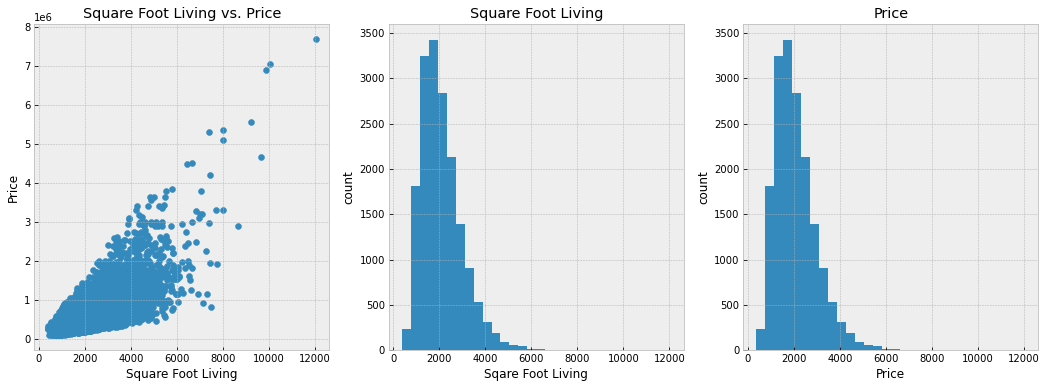

In [213]:
# Creates basemodel x_train
base_plots(X_train.sqft_living, y_train)

The histograms for count and price show that the data is a bit skewed to the left. If our model performs poorly maybe we can check if the log of these variable will perform better.

In [214]:
def base_model(x_train, y_train):
    '''
    Returns the Rsquared value from 10 randomly selected training
    and test sets from the set provided
    
    inputs: X_train, y_train
    output: array of Train Rsquared values,
            array of Test Rsquared values,
            timing statistics
    '''
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_validate, ShuffleSplit
    
#     Start a linear regression model
    lr = LinearRegression()
    
#     Create a random splitter, randomly selects 10 sets of train:test sets
    splitter = ShuffleSplit(n_splits=10, test_size=0.20, random_state=1)

#     Creates models for the 10 sets, returns Rsqared score for each
    baseline_scores = cross_validate(
        estimator=lr,
        X=x_train,
        y=y_train,
        return_train_score=True,
        cv=splitter
    )

    return baseline_scores

In [215]:
base_results = base_model(X_train[['sqft_living']], y_train)
print('Baseline Train Rsquared Score: {}'.format(round(base_results['train_score'].mean(), 5)))
print('Baseline Test Rsquared Score: {}'.format(round(base_results['test_score'].mean(), 5)))

Baseline Train Rsquared Score: 0.49028
Baseline Test Rsquared Score: 0.49105


The resulting R<sup>2</sup> score has our modeling explaining only 49% of of our target variables variance. The Train and Test scores also very close. This shows that this model is underfit with a large bias and low variance. Let's take a quick look at the logs of these variables and the resulting model.

In [216]:
def base_plots_log(x, y):
    '''
    Figure to plot log scatter and histograms for price and sqft_living for base model
    Inputs: x=price, y=sqft_living
    Output: Scatter plot of log price vs. log sqft_living,
            histograms of log price and log sqft_living
    '''
    
    fig, axes = plt.subplots(figsize=(18,6), ncols=3, nrows=1)
    
#     takes log of variable
    x_log = np.log(x)
    y_log = np.log(y)
    
#     log Price vs log Square Foot Living Scatter Plot
    axes[0].scatter(x_log,y_log)
    axes[0].set_ylabel('log(Price)')
    axes[0].set_xlabel('log(Square Foot Living)')
    axes[0].set_title('Square Foot Living vs. Price')
    
#     Log Square Foot Living Histogram
    axes[1].hist(x_log, bins=30)
    axes[1].set_xlabel('log(Sqare Foot Living)')
    axes[1].set_ylabel('count')
    axes[1].set_title('Square Foot Living')
    
#     Log Price Histrogram
    axes[2].hist(x_log, bins=30)
    axes[2].set_xlabel('log(Price)')
    axes[2].set_ylabel('count')
    axes[2].set_title('Price')

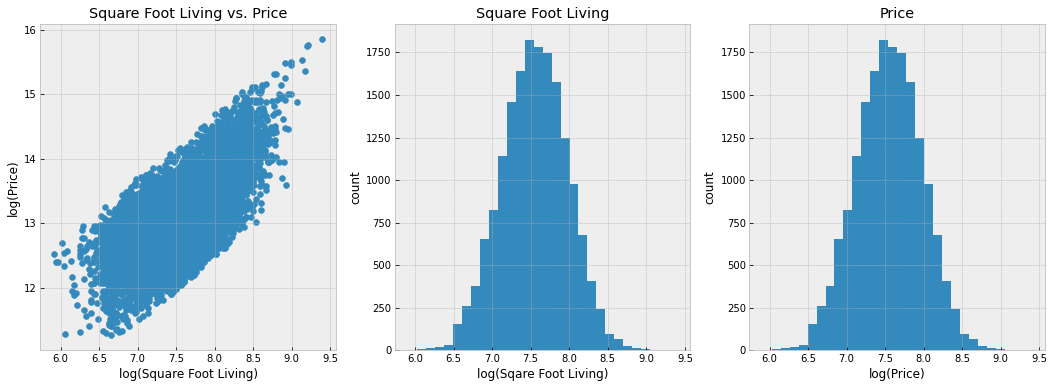

In [217]:
# Plots the log transformed figures
base_plots_log(X_train.sqft_living, y_train)

It appears that the log of both variables is very similar to a normal distribution. Let's now test the linear regression model created from these variables.

In [218]:
base_results_log = base_model(np.log(X_train[['sqft_living']]), np.log(y_train))
print('Baseline log Train Rsquared Score: {}'.format(round(base_results_log['train_score'].mean(), 5)))
print('Baseline log Test Rsquared Score: {}'.format(round(base_results_log['test_score'].mean(), 5)))

Baseline log Train Rsquared Score: 0.45296
Baseline log Test Rsquared Score: 0.45979


The R<sup>2</sup> scores have actually gone down compared to our original model. Therefore the previous model will be kept as our baseline model. 

### Model With all Features

Let's create a model containing all the features deemed important. Looking at all the independant variables histograms it looks like `bedrooms` and `sqft_living` have some outliers. To get rid of outliers it may benefit us to omit or change the values for `sqft_living` greater than 8000 and to take a closer look at bedrooms variables.

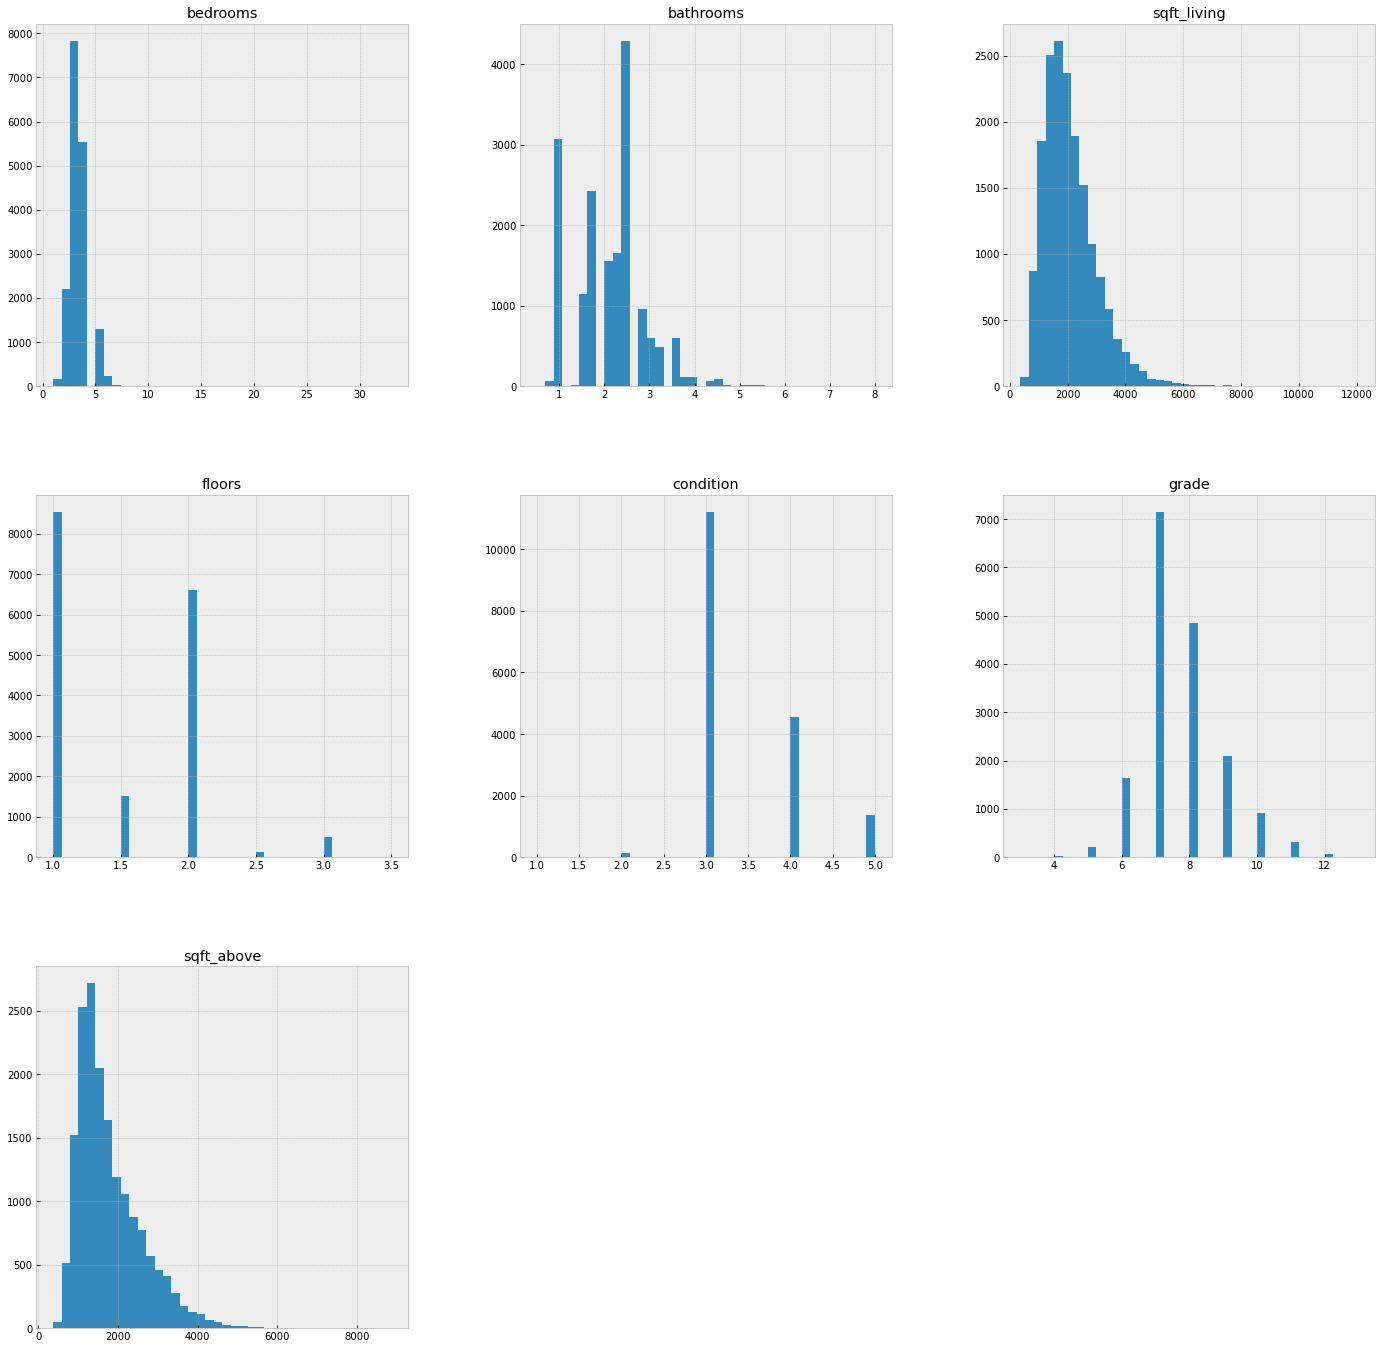

In [219]:
X_train.hist(figsize=(24,24), bins=40);

In [220]:
# Looking at bedroom values
X_train.bedrooms.value_counts()

3     7829
4     5539
2     2194
5     1284
6      223
1      162
7       27
8       10
9        6
11       1
10       1
33       1
Name: bedrooms, dtype: int64

In [221]:
len_of_outliers = len(X_train[(X_train.sqft_living > 8000)
                             | (X_train.bedrooms == 33)])
print('Percentage of outliers: {}%'.format(round(100*(len_of_outliers/len(X_train)), 4)))

Percentage of outliers: 0.0521%


These outliers only account for about .06% of the training data, thus will be omitted.

In [222]:
def omit_outliers(X_train, y_train):
    df = pd.concat([X_train, y_train], axis=1)
    
    df = df[(df.sqft_living <= 8000)
           & (df.bedrooms != 33)]
    
    y = df.price
    X = df.drop(columns='price', axis=1)
    
    return (X, y)

In [223]:
X_train, y_train = omit_outliers(X_train, y_train)

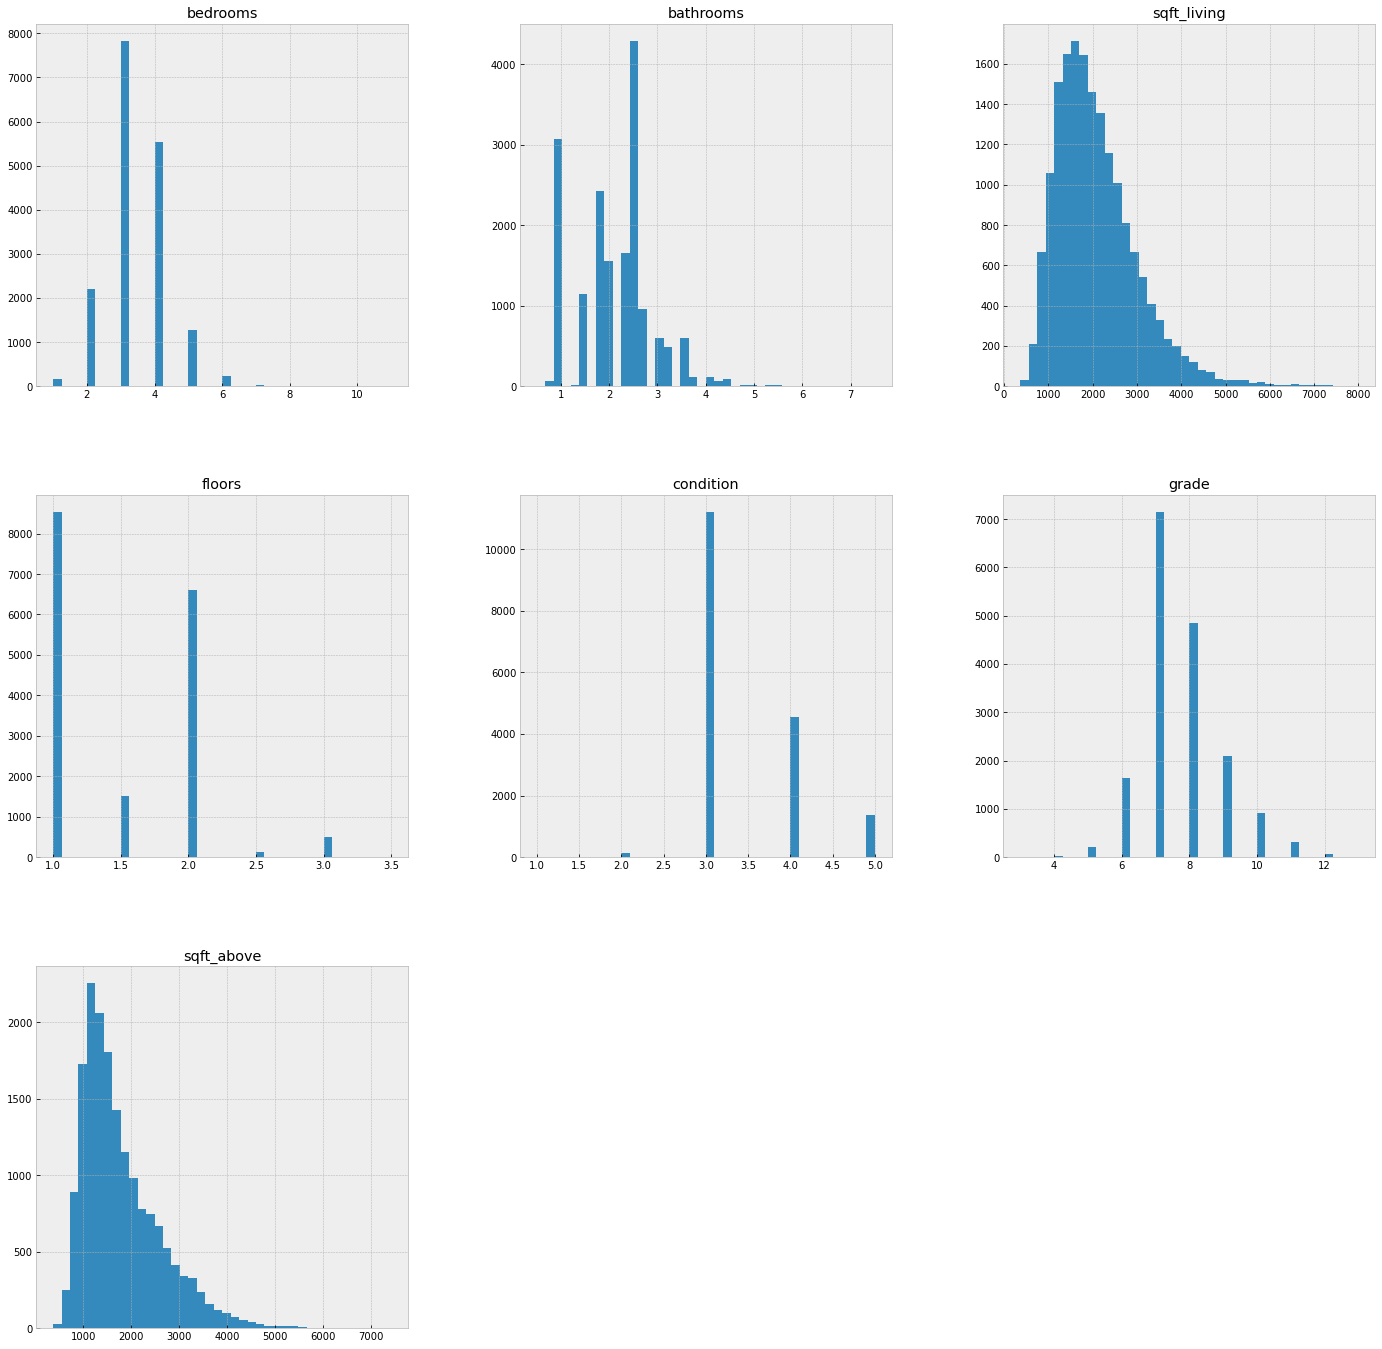

In [224]:
X_train.hist(figsize=(24,24), bins=40);

A few of these variable clearly don't have coninuous distribtuions and can be treated as categories. These columns include `bedrooms`, `floors`, `condition` and `grade`. This function will also standardize all continuous variables so they have similar scales.

In [225]:
def second_model_prep(X_train, y_train, categoricals):
    '''
    Creates dummy variables for categorical data.
    Standardizes continuous variables.
    Concatenates the dummy variables and continuous variables
    into one dataframe.
    
    inputs: (X_train, y_train, Categorical_columns)
    '''
    
    from sklearn.preprocessing import StandardScaler
    
#     Create dataframe with just category variables and changes
#     them to type category
    cat_df = X_train[categoricals].astype('category')

#     Creates dummy variables and drops firts column of each
#     set of dummy variables to help prevent multicollinearity
    cat_dummies = pd.get_dummies(cat_df, drop_first=True)

#     Drops categorical variables from original dataset
    X_train_cont = X_train.drop(categoricals, axis=1).copy()
    
#     Stardardizes numerical columns
    X_train_stand = StandardScaler().fit_transform(X_train_cont)
    X_train_stand = pd.DataFrame(X_train_stand, 
                                 columns=X_train_cont.columns,
                                 index=X_train_cont.index)
    
#     Concatinates dummy variables and standardized continuous variables
    X_train_prep = pd.concat([X_train_stand, cat_dummies], axis=1)    
    
    return X_train_prep

In [226]:
# Categorical columns to be One Hot Encoded
categoricals = ['bedrooms', 'floors', 'condition', 'grade']

# One hot encodes categoricals and standardizes continuous variables
X_train_model2 = second_model_prep(X_train, y_train, categoricals)

# Display first 5 entries
X_train_model2.head()

,bathrooms,sqft_living,sqft_above,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
5931,-1.459071,-0.331557,-0.887196,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
19984,0.500809,-0.907996,-0.643171,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
13637,-0.479131,0.067516,-0.862794,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11462,1.807395,-0.819313,-0.862794,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
19036,-1.459071,-1.151874,-0.911599,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Now to check the performance of the models created by this dataset.

In [227]:
def second_model2(X_train, y_train):
    '''
    Returns the Rsquared value from 10 randomly selected training
    and test sets from the set provided

    inputs: (X_train (standardized and OHE), 
             y_train)
    output: array of Train Rsquared values,
            array of Test Rsquared values,
            timing statistics
    '''
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_validate, ShuffleSplit
    
#     Start a linear regression model
    lr = LinearRegression()
    
#     Create a random splitter, randomly selects 10 sets of train:test sets
    splitter = ShuffleSplit(n_splits=10, test_size=0.20, random_state=1)

#     Creates models for the 10 sets, returns Rsqared score for each
    baseline_scores = cross_validate(
        estimator=lr,
        X=X_train,
        y=y_train,
        return_train_score=True,
        cv=splitter
    )

    return (baseline_scores)

In [230]:
model2_results_prep = second_model2(X_train_model2, y_train)
print('Second Model Train Rsquared Score: {}'.format(round(model2_results_prep['train_score'].mean(), 5)))
print('Second Model Test Rsquared Score: {}\n'.format(round(model2_results_prep['test_score'].mean(), 5)))

print('Baseline log Train Rsquared Score: {}'.format(round(base_results_log['train_score'].mean(), 5)))
print('Baseline log Test Rsquared Score: {}'.format(round(base_results_log['test_score'].mean(), 5)))

Second Model Train Rsquared Score: 0.60441
Second Model Test Rsquared Score: 0.60253

Baseline log Train Rsquared Score: 0.45296
Baseline log Test Rsquared Score: 0.45979


There is some clear improvement in the R<sup>2</sup> values of our second model. This model now explain around 60% of our target variables variance. While we did improve our bias by a decent amount, it is still pretty high. Our training and test scores are also still very close so our variance is low. This means we still have a pretty underfit model.

Let's check if adding some feature interactions will improve our data set.

'''
Initial notes on columns:

Dropable Columns: ['id', 'date', 'lat', 'long']

Missing Data or Misunderstood Data (NaN): waterfront, view, yr_renovated
**Need to research document to find more information on NaN values

Data Input: 
    Object Columns: categoricals = ['waterfront', 'view', 'condition', 'grade']
    *** Not sure yet how I want to deal with grade
    
grade: contains numeric and written classification, should get rid of written classification

yr_renovated: has both 0 and NaN inputs, look into this 

waterfront: has both no and NaN

view: has both None and NaN

Data needs to be normalized: Columns including sqft have large values, also some have zero values because they
don't exist in those homes

sqft_lots has some outliers, may need to be cut off
bedrooms has a clear outlier of 33, possibly even 10 and 11
Maybe split year built into segments and categorize them.
'''